In [27]:
import json
import os
import pickle
import time

import csv
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 10, 8

# from warnings import simplefilter
# simplefilter(action='ignore', category=FutureWarning)

In [76]:
DIR = '/Users/awang/Documents/OrangeC93'
URL = 'https://query.data.world/s/xpasnutccmyrw3waw3svhfsxqy42p4'

# Diagnosis (M = malignant, B = benign) 
df = pd.read_csv(URL)

In [77]:
df = df.drop(['id','Unnamed: 32'], axis=1)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64


In [81]:
def split_xy(data):
    ys = ['diagnosis']  
    y = pd.DataFrame(data[ys])
    X = data.drop(ys, axis=1)

    return X, y

In [82]:
def transformation(X, y):
#     # Encode the categorical data with one-hot encoding
#     X = pd.get_dummies(data[features])

#     # Standardization(Z-Score): have a mean of zero and a standard deviation of 1

#     # Log
#     for field in list(X):
#         X[f'log_{field}'] = np.log(X[field] + 1)

    # Normalization: scale a variable to have a values between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # Convert unique classes (strings) into integers
    encoder = LabelEncoder()
    encoder.fit(['B', 'M'])
    y = encoder.transform(y)
    
    return X, y

In [84]:
X, y = split_xy(df)
X, y = transformation(X, y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [68]:
param_grid = {'penalty' : ['l2'], 'C' : np.logspace(-4, 0, 40)}
clf = GridSearchCV(LogisticRegression(solver='lbfgs',
                                      class_weight='balanced'), 
                   param_grid,
                   cv=10)
best = clf.fit(X_train, y_train)

print('Best Penalty:', best.best_estimator_.get_params()['penalty'])
print('Best C:', best.best_estimator_.get_params()['C'])
print('Best Score:', best.best_score_)

Best Penalty: l2
Best C: 0.7896522868499725
Best Score: 0.9758241758241758


In [69]:
scores = []
recalls = []
precisions = []
f1 = []
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model = LogisticRegression(C=best.best_estimator_.get_params()['C'],
                           solver='lbfgs',
                           class_weight='balanced')
cv = KFold(n_splits=10, random_state=42, shuffle=False)
X, y = load_data()
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index],\
                                       X[test_index],\
                                       y[train_index],\
                                       y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = sum(np.diag(cm)) / np.sum(cm)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * precision * recall / (precision + recall)
    scores.append(acc)
    recalls.append(recall)
    precisions.append(precision)
    f1.append(F1)
    
print(sum(scores)/len(scores))
print(sum(recalls)/len(recalls))
print(sum(precisions)/len(precisions))
print(sum(f1)/len(f1))

0.9701127819548871
0.9574309748222791
0.9598025163242555
0.9581961650500975


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
def get_ranked_coefs(predictors, logistic_clf):
    coefs = pd.DataFrame(
        [[pred, coef] for pred, coef in zip(predictors, 
                                            logistic_clf.coef_[0])], 
        columns=['predictor', 'coef'])
    coefs['abs'] = np.abs(coefs.coef)
    coefs = coefs.sort_values('abs', ascending=False)
    coefs = coefs.drop(['abs'], axis=1)
    return coefs

predictors = list(df.iloc[:,1:])
coefs = get_ranked_coefs(predictors, model)
coefs.head()

,predictor,coef
27,concave points_worst,2.031508
20,radius_worst,1.688426
21,texture_worst,1.597322
22,perimeter_worst,1.574019
7,concave points_mean,1.546819


In [55]:
def get_auc(target, preds):
    fpr, tpr, _ = roc_curve(target, preds)
    mod_auc = auc(fpr, tpr)
    print('AUC:      ', mod_auc)
    return { 'fpr': fpr, 'tpr': tpr, 'auc': mod_auc }

In [56]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, 'k')
    plt.plot([0, 1], [0, 1], 'r')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')

AUC:       0.9499105545617172


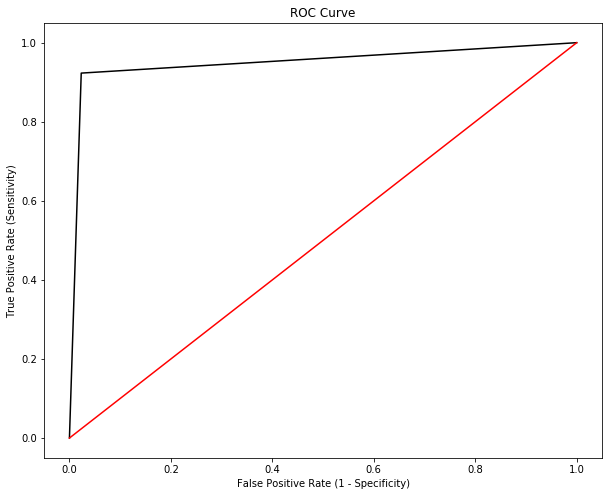

In [57]:
auc_metrics = get_auc(y_test, y_pred)
plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])